In [1]:
import pandas as pd

In [25]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [38]:
import pickle

In [87]:
import re

In [2]:
df = pd.read_csv("英国_商科_applicants.csv")

In [3]:
df.head()

,school,applicant
0,卡迪夫大学国际经济学、银行与金融理学硕士,"郑州航空工业管理学院, 经济学, 三年以上工作经验，GPA76.01，无"
1,格拉斯哥大学信息管理与保存理学硕士,"华东师范大学, 信息管理与信息系统, 已毕业，GPA81.52，无"
2,剑桥大学经济学哲学硕士,"中央财经大学, 国际经济与贸易（国际贸易/金融风险管理方向）, 大四，GPA91.72，雅思..."
3,伦敦大学国王学院金融学（资产定价）理学硕士,"中国海洋大学, 金融学, 大四，GPA97.93，无"
4,南安普顿大学会计与管理理学硕士,"湖南农业大学, 金融学, 大四，GPA81.2，暂无"


In [21]:
df['applicant_school'] = df['applicant'].apply(lambda x: x.split(',')[0].strip())

In [14]:
chinese_schools = pd.read_csv("chinese_universities.csv",header=None)

In [16]:
chinese_schools.columns=['id', 'school_name', 'school_id', 'relation', 'location', 'type', 'note']

In [29]:
def match_school(school):
    if school in list(chinese_schools['school_name'].unique()):
        return 1
    for s in list(chinese_schools['school_name'].unique()):
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [34]:
df['is_chinese_undergrad'] = df['applicant_school'].apply(match_school)

In [40]:
with open('211.pickle', 'rb') as f:
    school_211 = pickle.load(f)

In [42]:
with open('985.pickle', 'rb') as f:
    school_985 = pickle.load(f)

In [45]:
def is_school_985(school):
    if school in school_985:
        return 1
    for s in school_985:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [46]:
def is_school_211(school):
    if school in school_211:
        return 1
    for s in school_211:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [47]:
df['is_985'] = df['applicant_school'].apply(is_school_985)
df['is_211'] = df['applicant_school'].apply(is_school_211)

In [163]:
zhuanke_schools = chinese_schools[chinese_schools['type'] == '专科']['school_name'].to_list()

In [150]:
def is_school_zhuanke(school):
    if school in zhuanke_schools:
        return 1
    for s in zhuanke_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [165]:
df['is_zhuanke'] = df['applicant_school'].apply(is_school_zhuanke)

In [167]:
minban_schools = chinese_schools[chinese_schools['note'] == '民办']['school_name'].to_list()
heban_schools = chinese_schools[((chinese_schools['note'] == '中外合作办学') | (chinese_schools['note'] == '内地与港澳台地区合作办学'))]['school_name'].to_list()

In [169]:
def is_school_minban(school):
    if school in minban_schools:
        return 1
    for s in minban_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [170]:
def is_school_heban(school):
    if school in heban_schools:
        return 1
    for s in heban_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [171]:
df['is_minban'] = df['applicant_school'].apply(is_school_minban)
df['is_heban'] = df['applicant_school'].apply(is_school_heban)

In [79]:
qs_rankings = pd.read_csv('qs_ranking_top_100.csv')

In [82]:
def is_school_top_100_qs(school):
    top_qs_100_schools = qs_rankings['ch_name'].to_list() + qs_rankings['en_name'].to_list()
    for s in top_qs_100_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [103]:
df['is_top_100_qs'] = df['applicant_school'].apply(is_school_top_100_qs)

In [122]:
def extract_gpa(txt):
    ## I'm really bad at regular expression and i don't intend to optimize it.
    try:
        pattern = r"GPA\d+\.\d+"

        result = re.findall(pattern, txt)
        if not bool(result):
            pattern = r"GPA\d+"
            result = re.findall(pattern, txt)
        if not bool(result):
            pattern = r"GPA \d+"
            result = re.findall(pattern, txt)
        return result[0]
    except IndexError:
        return None

In [120]:
df['gpa'] = df['applicant'].apply(extract_gpa)

In [124]:
df['gpa'] = df['gpa'].apply(lambda x: x.replace('GPA', '').strip())

In [126]:
df['gpa'] = pd.to_numeric(df['gpa'])

In [142]:
def transform_gpa(gpa):
    if gpa <= 5:
        return (gpa + 1) * 20
    if gpa <= 20: # weird systems
        return None
    return gpa

In [143]:
df['gpa'] = df['gpa'].apply(transform_gpa)

In [174]:
major_all = pd.read_csv("指南者专业信息全.csv")

In [176]:
major_all['qs_ranking'] = major_all['ranking'].apply(lambda x: int(x.split("：")[1].strip().replace("+", "")))

In [181]:
df = df.merge(major_all[['ch_name', 'qs_ranking']], left_on='school', right_on='ch_name', how='left')

In [185]:
df = df.drop(['ch_name'], axis=1)

In [232]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [216]:
_df = df[df['qs_ranking'].notna()]
_df = _df[_df['gpa'].notna()]

In [217]:
y = _df['qs_ranking']
x = _df[['is_chinese_undergrad', 'is_985', 'is_211', 'is_top_100_qs', 'gpa', 'is_zhuanke', 'is_minban', 'is_heban']]

In [223]:
model = GradientBoostingRegressor(n_estimators=10)

In [220]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=23)

In [224]:
model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=10)

In [225]:
y_pred = model.predict(X_valid)

In [230]:
np.sqrt(mean_squared_error(y_pred, y_valid))

51.71751160566586

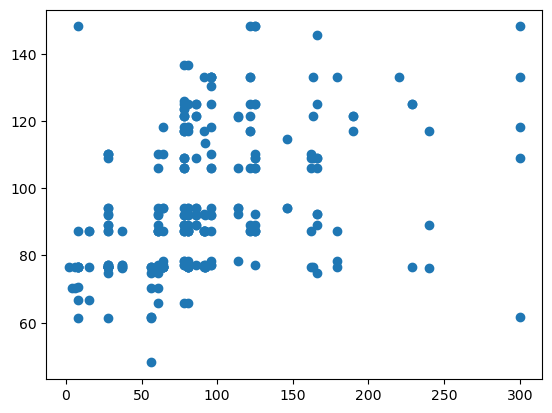

In [235]:
plt.scatter(y_valid, y_pred)

## Using k neartest neighbor instead

In [236]:
df.head()

,school,applicant,applicant_school,is_chinese_undergrad,is_985,is_211,is_top_100_qs,gpa,is_zhuanke,is_minban,is_heban,qs_ranking
0,卡迪夫大学国际经济学、银行与金融理学硕士,"郑州航空工业管理学院, 经济学, 三年以上工作经验，GPA76.01，无",郑州航空工业管理学院,1,0,0,0,76.01,0,0,0,166.0
1,格拉斯哥大学信息管理与保存理学硕士,"华东师范大学, 信息管理与信息系统, 已毕业，GPA81.52，无",华东师范大学,1,1,1,0,81.52,0,0,0,81.0
2,剑桥大学经济学哲学硕士,"中央财经大学, 国际经济与贸易（国际贸易/金融风险管理方向）, 大四，GPA91.72，雅思...",中央财经大学,1,0,1,0,91.72,0,0,0,2.0
3,伦敦大学国王学院金融学（资产定价）理学硕士,"中国海洋大学, 金融学, 大四，GPA97.93，无",中国海洋大学,1,1,1,0,97.93,0,0,0,37.0
4,南安普顿大学会计与管理理学硕士,"湖南农业大学, 金融学, 大四，GPA81.2，暂无",湖南农业大学,1,0,0,0,81.20,0,1,0,78.0


In [241]:
_df['gpa_normalized'] = (_df['gpa'] - _df['gpa'].mean()) / _df['gpa'].std()

In [238]:
from sklearn.neighbors import NearestNeighbors

In [239]:
model = NearestNeighbors()

In [243]:
train_data = _df[['is_chinese_undergrad', 'is_985', 'is_211', 'is_top_100_qs', 'is_zhuanke', 'is_minban', 'is_heban', 'gpa_normalized']]

In [242]:
model.fit(train_data)

NearestNeighbors()

In [265]:
model.kneighbors([train_data.iloc[100]], n_neighbors=10)

/Users/leilingtao/anaconda/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.        , 0.00461349, 0.00461349, 0.00461349, 0.00461349,
         0.0199918 , 0.03537011, 0.03537011, 0.06920239, 0.06920239]]),
 array([[100, 529, 550, 527, 560, 699, 682, 769, 766, 576]]))

In [260]:
_df.iloc[100]

school                                   南安普顿大学经济学理学硕士
applicant               北京工业大学, 经济统计学, 已毕业，GPA86.21，暂无
applicant_school                                北京工业大学
is_chinese_undergrad                                 1
is_985                                               1
is_211                                               1
is_top_100_qs                                        0
gpa                                              86.21
is_zhuanke                                           0
is_minban                                            1
is_heban                                             0
qs_ranking                                        78.0
gpa_normalized                                0.269103
Name: 100, dtype: object

In [266]:
_df.iloc[576]

school                               曼彻斯特大学国际时尚营销理学硕士
applicant               北京理工大学珠海学院, 商务英语, 大四，GPA86.66
applicant_school                           北京理工大学珠海学院
is_chinese_undergrad                                1
is_985                                              1
is_211                                              1
is_top_100_qs                                       0
gpa                                             86.66
is_zhuanke                                          0
is_minban                                           1
is_heban                                            0
qs_ranking                                       28.0
gpa_normalized                               0.338305
Name: 596, dtype: object

In [270]:
_df.iloc[[100, 529, 550, 527, 560, 699, 682, 769, 766, 576]]['qs_ranking']

100     78.0
546     64.0
568     92.0
544     64.0
579     61.0
739     37.0
716     81.0
816     64.0
811    162.0
596     28.0
Name: qs_ranking, dtype: float64

In [274]:
_df[_df['qs_ranking'] <= 40]['qs_ranking'].unique()

array([ 2., 37., 28., 15.,  8.,  6.,  4.])

## business logic

1. Find 12 nearest neighbor based on all dataset, get the list of available qs_rankings
2. Based on the 12 nearest neighbors, get the top 3, middle 6 and bottom 3 qs_rankings
3. Translate that into corresponding tiers (i.e. if avg of top 3 is 20, then find 10 - 30)
4. For each tier, find if there're corresponding schools/majors in the region
5. apply filter (language and tuition)
6. return the tiers

In [275]:
import os

In [276]:
all_applicant_df_fns = []
for fn in os.listdir('.'):
    if '_applicants.csv' in fn:
        all_applicant_df_fns.append(fn)

In [298]:
all_applicant_dfs = [pd.read_csv(f'{t}') for t in all_applicant_df_fns]

In [301]:
for df_fn, df in zip(all_applicant_df_fns, all_applicant_dfs):
    df['fn'] = df_fn

In [302]:
all_applicant_dfs = pd.concat(all_applicant_dfs)

In [320]:
def process_applicant_df(df):
    df['gpa'] = df['applicant'].apply(extract_gpa)
    df['gpa'] = df['gpa'].apply(lambda x: x.replace('GPA', '').strip() if bool(x) else None)
    df['gpa'] = pd.to_numeric(df['gpa'])
    df['gpa'] = df['gpa'].apply(transform_gpa)
    df['gpa_normalized'] = (df['gpa'] - df['gpa'].mean()) / df['gpa'].std()
    df['applicant_school'] = df['applicant'].apply(lambda x: x.split(',')[0].strip())
    df['is_chinese_undergrad'] = df['applicant_school'].apply(match_school)
    df['is_985'] = df['applicant_school'].apply(is_school_985)
    df['is_211'] = df['applicant_school'].apply(is_school_211)
    df['is_zhuanke'] = df['applicant_school'].apply(is_school_zhuanke)
    df['is_minban'] = df['applicant_school'].apply(is_school_minban)
    df['is_heban'] = df['applicant_school'].apply(is_school_heban)
    df['is_top_100_qs'] = df['applicant_school'].apply(is_school_top_100_qs)
    df['school'] = df['school'].apply(lambda x: x.replace('offer一枚', ''))
    return df

In [322]:
t = process_applicant_df(all_applicant_dfs)

In [321]:
all_applicant_dfs

,school,applicant,fn
0,香港科技大学工程企业管理理学硕士,"中山大学, 材料物理, 两年工作经验，GPA3.5，雅思7.0",香港_工科_applicants.csv
1,香港大学工程学（机械工程）理学硕士,"上海交通大学, 船舶与海洋工程, 已毕业，GPA2.97，雅思6.5",香港_工科_applicants.csv
2,香港城市大学工程管理学理学硕士,"福州大学, 工程管理, 大四，GPA83.75，托福:101(L:29/R:30/W:21/...",香港_工科_applicants.csv
3,香港大学工程学（机械工程）理学硕士,"西安交通大学, 工业设计, 大四，GPA3.81，雅思8，GRE333",香港_工科_applicants.csv
4,香港大学工程学（机械工程）理学硕士,"布里斯托大学, 机械工程, 大四，GPA68.67，不需要",香港_工科_applicants.csv
...,...,...,...
975,伦敦大学学院能源环境经济与政策理学硕士,"四川大学, 金融学（双语）, 大四，GPA 88分，托福110分",英国_工科_applicants.csv
976,华威大学供应链与物流管理理学硕士,"华东理工大学, 自动化, 大四，GPA81分，雅思6.5分",英国_工科_applicants.csv
977,莱斯特大学信息与通信工程理学硕士offer一枚,"南京理工大学, 通信工程, 包同学，南京理工大学，通信工程，GPA75分，雅思6分",英国_工科_applicants.csv
978,伦敦大学学院软件系统工程理学硕士,"武汉理工大学, 工程管理, 大四，GPA82分，雅思6.5",英国_工科_applicants.csv


In [323]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 0 to 979
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   school                11980 non-null  object 
 1   applicant             11980 non-null  object 
 2   fn                    11980 non-null  object 
 3   gpa                   11912 non-null  float64
 4   gpa_normalized        11912 non-null  float64
 5   applicant_school      11980 non-null  object 
 6   is_chinese_undergrad  11980 non-null  int64  
 7   is_985                11980 non-null  int64  
 8   is_211                11980 non-null  int64  
 9   is_zhuanke            11980 non-null  int64  
 10  is_minban             11980 non-null  int64  
 11  is_heban              11980 non-null  int64  
 12  is_top_100_qs         11980 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.3+ MB


In [324]:
_t = t.merge(major_all[['ch_name', 'qs_ranking']], left_on='school', right_on='ch_name', how='left')

In [342]:
major_all[major_all['region'] == 'Britain'].iloc[900:1000]

,en_name,ch_name,url,ranking,area,tofel,ielts,gmat,gre,tofel_sub,...,gmat_sub,gre_sub,curriculum,area_1,area_ranking,entrance_time,project_length,tuition,region,qs_ranking
1057,MSc Playwriting,爱丁堡大学剧本创作理学硕士,/majr_62623,QS排名：15,社科 影视,100,7,NaN,NaN,L:23 | R:23 | W:23 | S:23,...,NaN,NaN,"剧作家的技能, 表演的时间和空间, 研究前现代的手稿, 表现的自主性:传统与创新, 后殖民写...",影视,5,9月,1年,27100英镑/年,Britain,15
1058,MSc Sound Design,爱丁堡大学声音设计理学硕士,/majr_62629,QS排名：15,社科 影视,92,6.5,NaN,NaN,L:20 | R:20 | W:20 | S:20,...,NaN,NaN,"音频制作, 数字媒体工作室项目, 音乐大师毕业设计, 声波结构, 声学, 媒体和文化, 屏幕...",影视,5,9月,1年,28200英镑/年,Britain,15
1059,MA (eca) Film Directing,爱丁堡大学电影导演文学硕士,/majr_62969,QS排名：15,社科 影视,100,7,NaN,NaN,L:20 | R:20 | W:20 | S:20,...,NaN,NaN,"传播设计实践, 纪录片发展, 纪录片定稿：编辑, 拍摄纪录片",影视,5,9月,1年,28200英镑/年,Britain,15
1060,MSc Applied Animal Behaviour and Animal Welfare,爱丁堡大学应用动物行为与动物福利理学硕士,/majr_65825,QS排名：15,理科 生物,100,7,NaN,NaN,L:23 | R:23 | W:23 | S:23,...,NaN,NaN,"应用动物行为与动物福利概论, 痛苦生物学, 动物认知与意识, 科学方法论, 动物福利应用, ...",生物,5,9月,1年,24700英镑/年,Britain,15
1061,MSc Globalised Muslim World,爱丁堡大学全球穆斯林世界理学硕士,/majr_65833,QS排名：15,社科 其他社科,100,7,NaN,NaN,L:23 | R:23 | W:23 | S:23,...,NaN,NaN,"全球化穆斯林世界的区域视角, 穆斯林世界的国际、跨国和全球化动态, 研究技巧与方法, 穆斯林...",其他社科,6,9月,1年,27100英镑/年,Britain,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,MSc Sociological Research,曼彻斯特大学社会学研究理学硕士,/majr_62482,QS排名：28,社科 社会学与社工,100,7,NaN,NaN,L:22 | R:22 | W:25 | S:22,...,NaN,NaN,"社会理论与文化认同, 研究设计I, 研究设计II, 社会研究中的方法论问题, 定量方法简介,...",社会学与社工,4,9月,1年,23500英镑/年,Britain,28
1483,MSc Urban Studies,曼彻斯特大学城市研究理学硕士,/majr_72331,QS排名：28,社科 社会学与社工,100,7,NaN,NaN,L:25 | R:25 | W:25 | S:25,...,NaN,NaN,"城市研究中的关键问题, 研究城市, 大曼彻斯特地区的政策与政治活动, 全球城市未来, 论文",社会学与社工,4,9月,1年,23500英镑/年,Britain,28
1484,MA Humanitarianism and Conflict Response,曼彻斯特大学人道主义与冲突回应文学硕士,/majr_52634,QS排名：28,社科 国际关系,93,6.5,NaN,NaN,L:20 | R:20 | W:22 | S:20,...,NaN,NaN,"论文, 人道主义与冲突应对：查询, 研究与评估方法, 人道主义援助的历史, 跨境：流散的比较...",国际关系,11,9月,1年,26000英镑/年,Britain,28
1485,MA Peace and Conflict Studies,曼彻斯特大学和平与冲突研究文学硕士,/majr_52637,QS排名：28,社科 国际关系,100,7,NaN,NaN,L:22 | R:22 | W:25 | S:22,...,NaN,NaN,"和平与社会机构，安全与干预：理论与实践, 研究受冲突影响的社会的实用方法, 学位论文-MA和...",国际关系,11,9月,1年,25000英镑/年,Britain,28


In [308]:
t.to_csv("all_applicant_training_data.csv", index=None)

In [ ]:
def model_training(train_df):
    model = NearestNeighbors()
    model.fit(train_df)
    